In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

%matplotlib inline

In [54]:
PATH = os.path.abspath("/nfs/students/summer-term-2019/project-4/datasets/weather/40000_5_100_2_0_raw.pickle")

In [55]:
with open(PATH, "rb"):
    data_dict = pickle.load(open(PATH, "rb"))
    print(data_dict.keys())

dict_keys(['normalize_params', 'train_set', 'train_configurations', 'train_config_indices', 'valid_set', 'valid_configurations', 'valid_config_indices', 'test_set', 'test_configurations', 'test_config_indices'])


In [56]:
data = data_dict['train_set']

In [57]:
def plot_values(m, n_examples=2, rand=True):
    fig, axarr = plt.subplots(ncols=n_examples, nrows=2, figsize=(30, 10))
    indices = range(n_examples) if not rand else np.random.randint(0, len(data), size=(n_examples))
    for i, index in enumerate(indices):
        for atom_i in range(m.shape[1]):
            axarr[0, i].plot(m[index, atom_i, :, 0])
            axarr[1, i].plot(m[index, atom_i, :, 1])

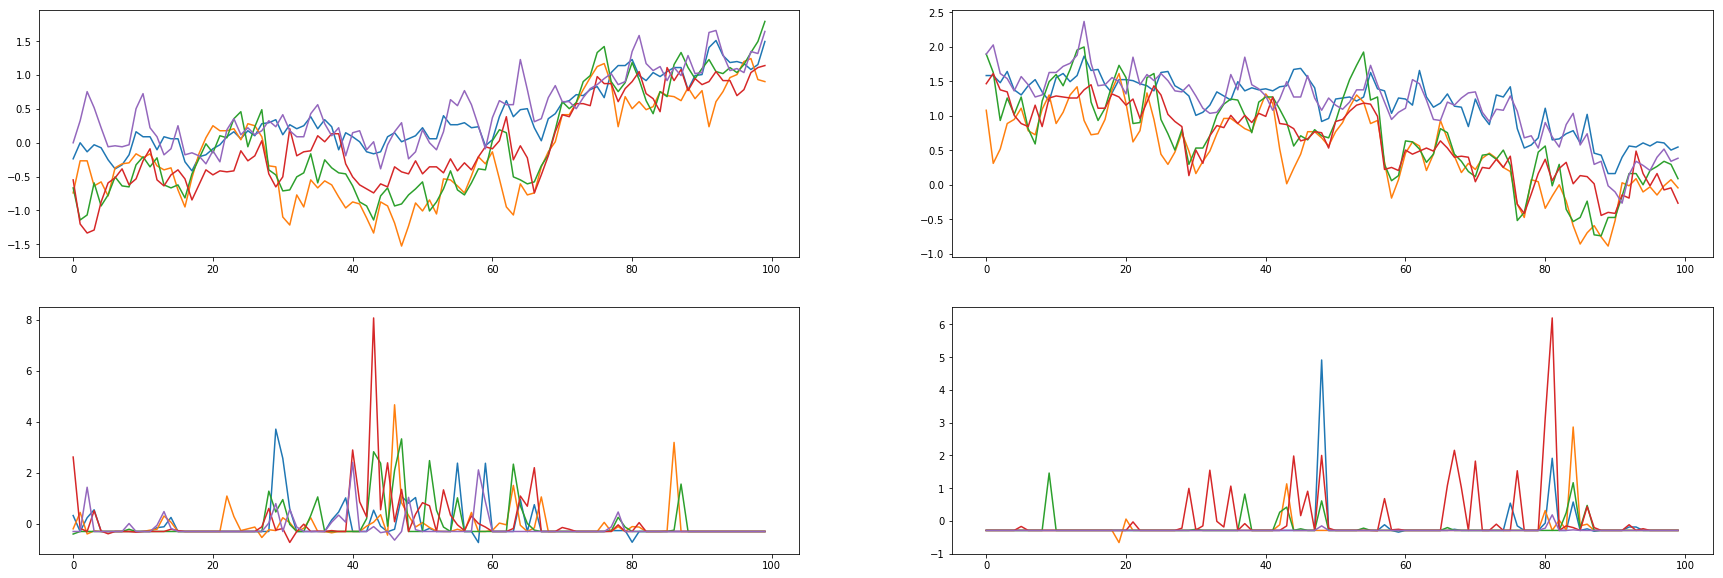

In [58]:
plot_values(data, rand=False)

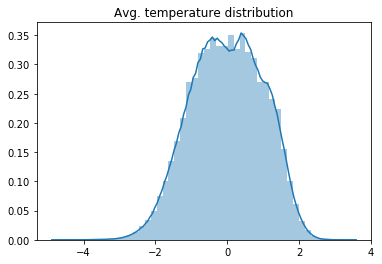

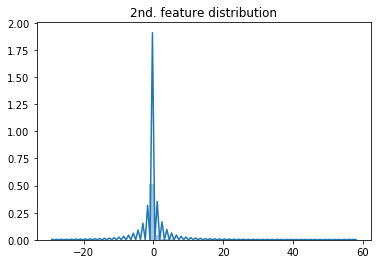

In [59]:
plt.title("Avg. temperature distribution")
sns.distplot(data[:, :, :, 0].flatten())
plt.figure()
plt.title("2nd. feature distribution")
sns.distplot(data[:, :, :, 1].flatten())

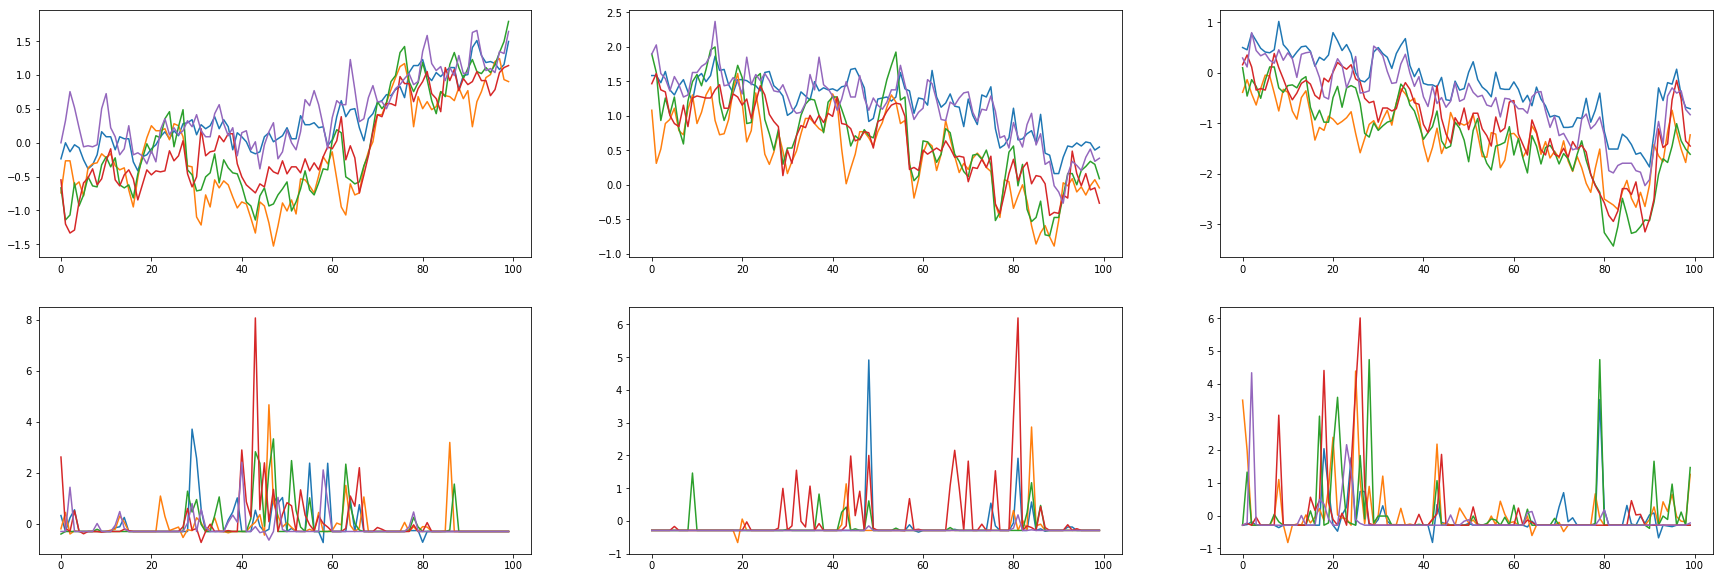

In [60]:
mean_temp = data[:, :, :, 0].mean()
std_temp = data[:, :, :, 0].std()
mean_humid = data[:, :, :, 1].mean()
std_humid = data[:, :, :, 1].std()

data_norm = data.copy()
data_norm[:,:,:,0] = (data_norm[:,:,:,0] - mean_temp) / std_temp
data_norm[:,:,:,1] = (data_norm[:,:,:,1] - mean_humid) / std_humid
plot_values(data_norm, n_examples=3, rand=False)

Stations interactions for first Example


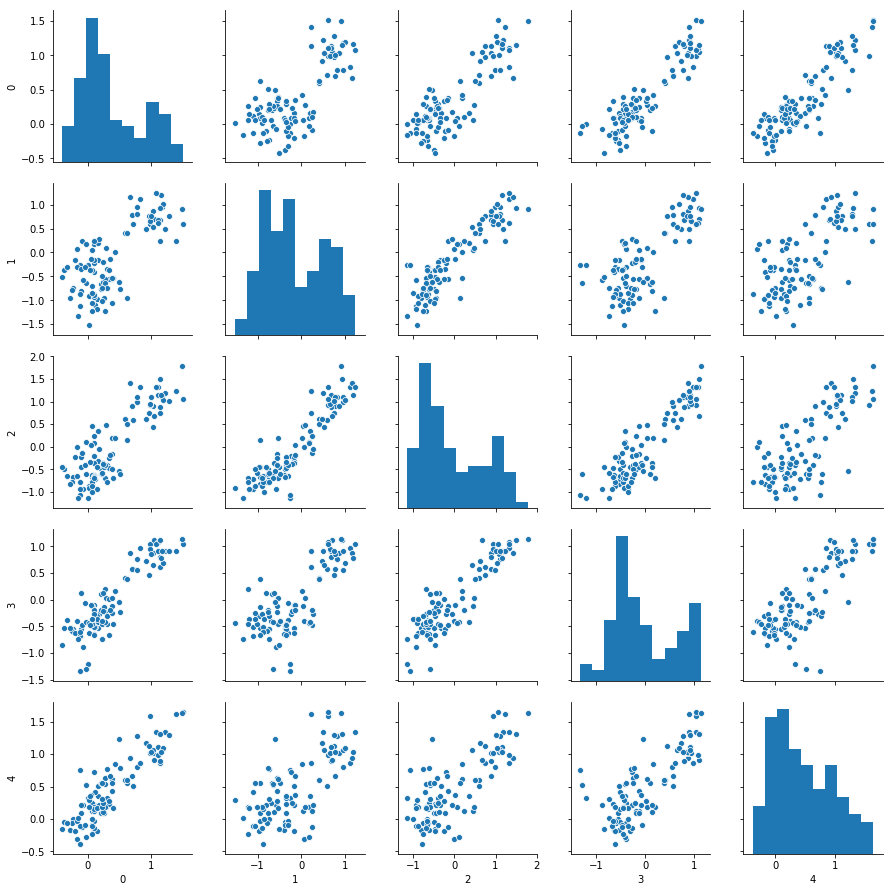

In [61]:
print("Stations interactions for first Example")
sns.pairplot(pd.DataFrame(data_norm[0, :, :, 0]).swapaxes(0, 1))

In [62]:
def exp_moving_avg(data, beta=0.3):
    smoothed = data.copy()
    timesteps = data.shape[2]
    for step in range(1, timesteps):
        smoothed[:, :, step, :] = beta * data[:, :, step, :] + (1 - beta) * smoothed[:, :, step - 1, :]
    return smoothed

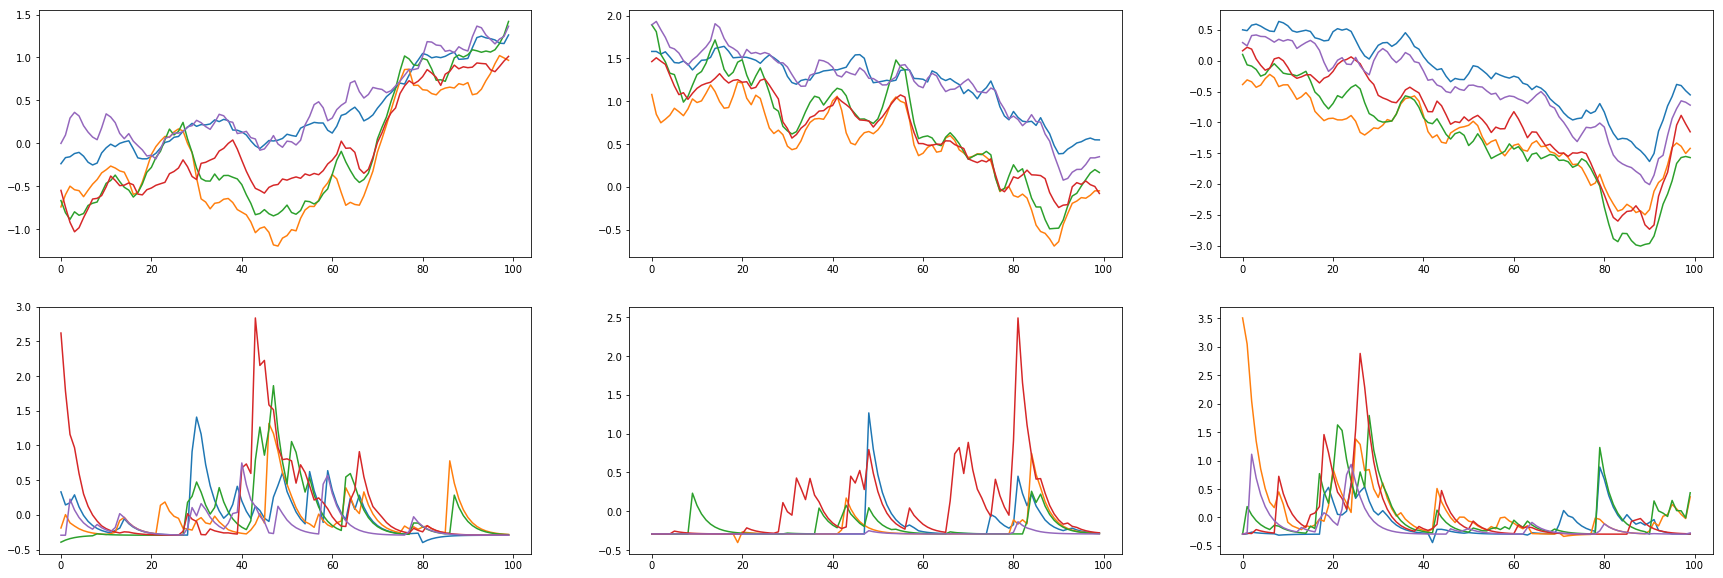

In [63]:
data_smoothed = exp_moving_avg(data)
plot_values(data_smoothed, n_examples=3, rand=False)

In [64]:
def moving_avg(data, window_size=5):
    assert window_size % 2 == 1, "Only symmetric windows allowed."
    smoothed = data.copy()
    timesteps = data.shape[2]
    start_i = window_size // 2
    print(f"Starting at {start_i} with window size {window_size}")
    for step in range(start_i, timesteps - start_i):
        val = sum([data[:, :, step - (start_i) + i] for i in range(window_size)]) / window_size
        smoothed[:, :, step, :] = val
    return smoothed

In [65]:
x = np.asanyarray([[[0.0, 1.0, 2.0, 3.0, 2.0, 1.0, 0.0]]])
x = x[:,:,:,np.newaxis]
x_smoothed = moving_avg(x, window_size=3)

Starting at 1 with window size 3


In [66]:
print((moving_avg(data, window_size=1) == data).all())
print(not (moving_avg(data, window_size=3) == data).all())

Starting at 0 with window size 1
True
Starting at 1 with window size 3
True


Starting at 1 with window size 3


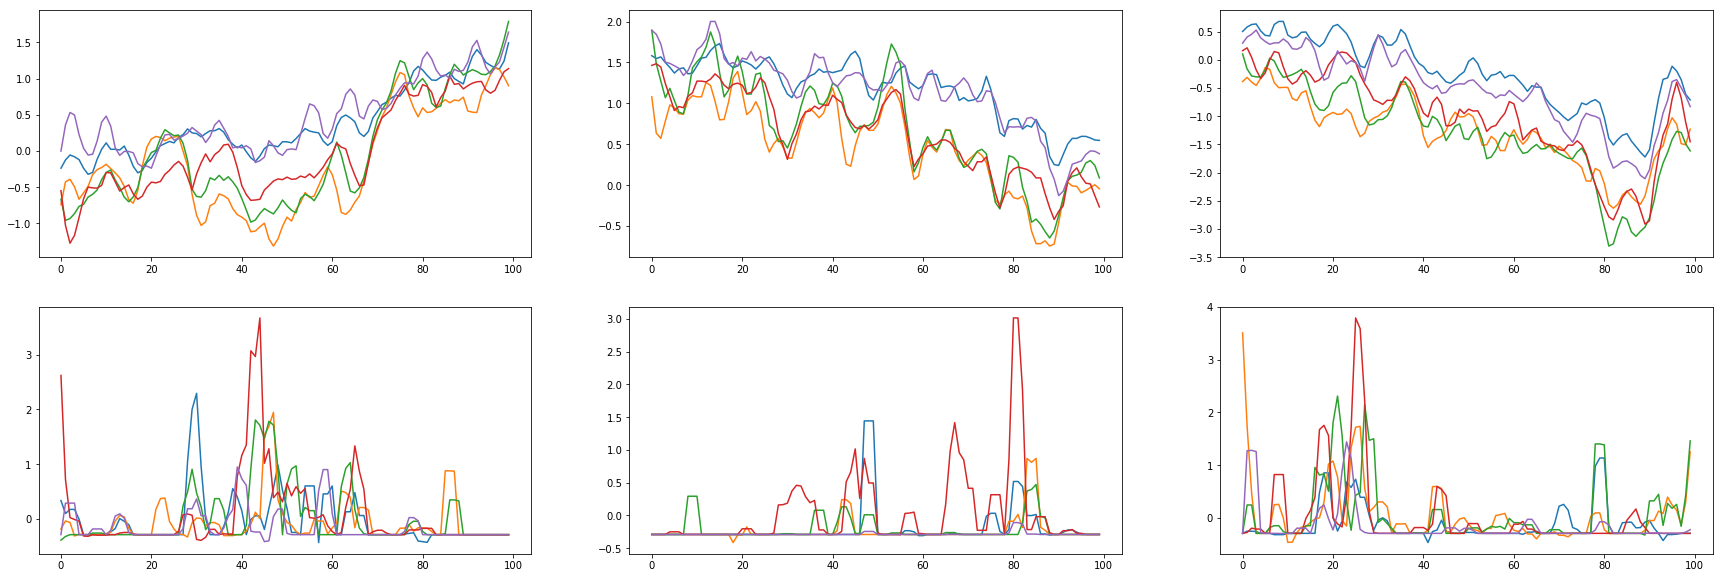

In [67]:
data_smoothed = moving_avg(data, window_size=3)
plot_values(data_smoothed, n_examples=3, rand=False)

Starting at 2 with window size 5


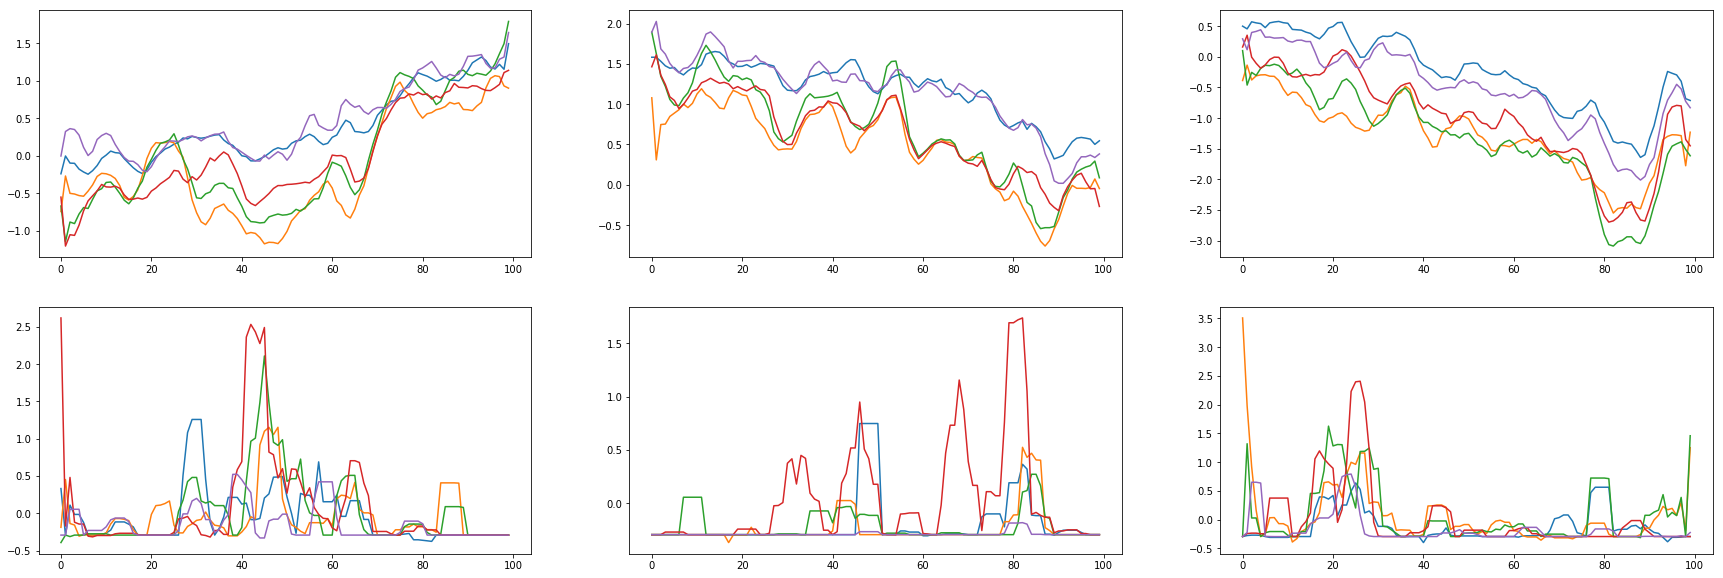

In [68]:
data_smoothed = moving_avg(data, window_size=5)
plot_values(data_smoothed, n_examples=3, rand=False)

Starting at 4 with window size 9


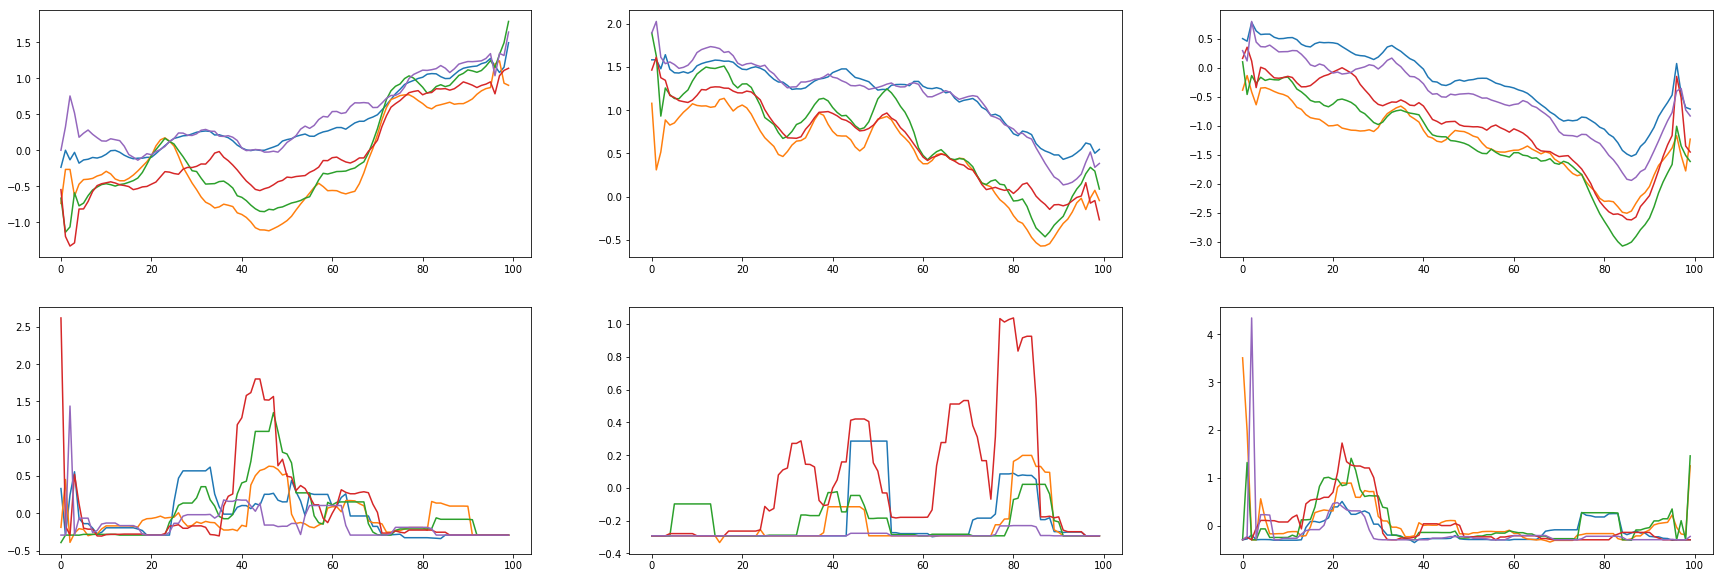

In [69]:
data_smoothed = moving_avg(data, window_size=9)
plot_values(data_smoothed, n_examples=3, rand=False)

In [70]:
from scipy import fft, ifft


def fourier(data, percentage_cut=.85):
    smoothed = data.copy()
    n_features = data.shape[-1]
    n_timesteps = data.shape[-2]
    for feat in range(n_features):
        data_feat = smoothed[:, :, :, feat]
        frequencies = fft(data_feat, axis=-1)
        frequencies[:, :, -int(percentage_cut * n_timesteps):] = 0
        smoothed[:, :, :, feat] = ifft(frequencies)
    return smoothed

/nfs/homedirs/grafberg/anaconda3/envs/mllab-venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


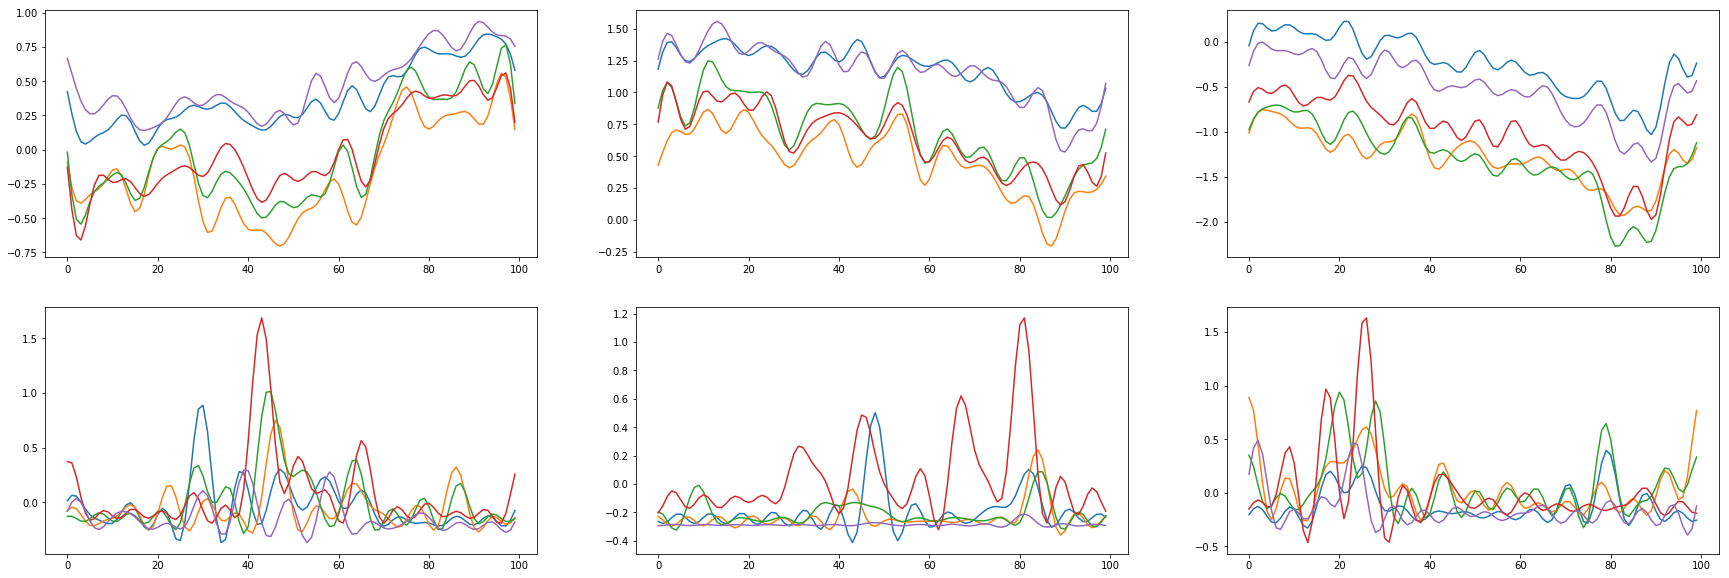

In [71]:
data_smoothed = fourier(data, percentage_cut=.85)
plot_values(data_smoothed, n_examples=3, rand=False)

In [72]:
from copy import deepcopy

def save_dataset(filename, data):
    print(f"Saving smoothed data under name {filename}")
    with open(filename, "wb") as f:
        pickle.dump(data, f)

#dict_keys(['normalize_params', 'train_set', 'train_configurations', 'train_config_indices', 'valid_set', 'valid_configurations', 'valid_config_indices', 'test_set', 'test_configurations', 'test_config_indices'])
    
def smooth_and_save(path, smoothing_function):
    # Load data first    
    with open(path, "rb") as f:
        data_dict = pickle.load(f)
        print(data_dict.keys())
    
    data_dict = deepcopy(data_dict)
    
    # Remove second feature
    for key in ['train_set', 'valid_set', 'test_set']:
        data_dict[key] = data_dict[key][:, :, :, 0][:, :, :, np.newaxis]
        print(f"{key} now has shape {data_dict[key].shape}") 
    data_dict['normalize_params'] = data_dict['normalize_params'][:1]

    # Perform smoothing on train set
    print(f"Smoothing data with {smoothing_function.__name__}")
    data_dict['train_set'] = smoothing_function(data_dict['train_set'])
    
    # Save
    new_path = path.split(".pickle")[0]
    new_path += str(smoothing_function.__name__) + ".pickle"
    save_dataset(new_path, data_dict)
    
    return data_dict

In [73]:
exp = smooth_and_save(PATH, exp_moving_avg)
fourier = smooth_and_save(PATH, fourier)

dict_keys(['normalize_params', 'train_set', 'train_configurations', 'train_config_indices', 'valid_set', 'valid_configurations', 'valid_config_indices', 'test_set', 'test_configurations', 'test_config_indices'])
train_set now has shape (32000, 5, 100, 1)
valid_set now has shape (4000, 5, 100, 1)
test_set now has shape (4000, 5, 100, 1)
Smoothing data with exp_moving_avg
Saving smoothed data under name /nfs/students/summer-term-2019/project-4/datasets/weather/40000_5_100_2_0_rawexp_moving_avg.pickle
dict_keys(['normalize_params', 'train_set', 'train_configurations', 'train_config_indices', 'valid_set', 'valid_configurations', 'valid_config_indices', 'test_set', 'test_configurations', 'test_config_indices'])
train_set now has shape (32000, 5, 100, 1)
valid_set now has shape (4000, 5, 100, 1)
test_set now has shape (4000, 5, 100, 1)
Smoothing data with fourier


/nfs/homedirs/grafberg/anaconda3/envs/mllab-venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


Saving smoothed data under name /nfs/students/summer-term-2019/project-4/datasets/weather/40000_5_100_2_0_rawfourier.pickle


In [47]:
def plot_values(m, n_examples=2, rand=True):
    fig, axarr = plt.subplots(ncols=n_examples, nrows=1, figsize=(30, 5))
    indices = range(n_examples) if not rand else np.random.randint(0, len(data), size=(n_examples))
    for i, index in enumerate(indices):
        for atom_i in range(m.shape[1]):
            axarr[i].plot(m[index, atom_i, :, 0])

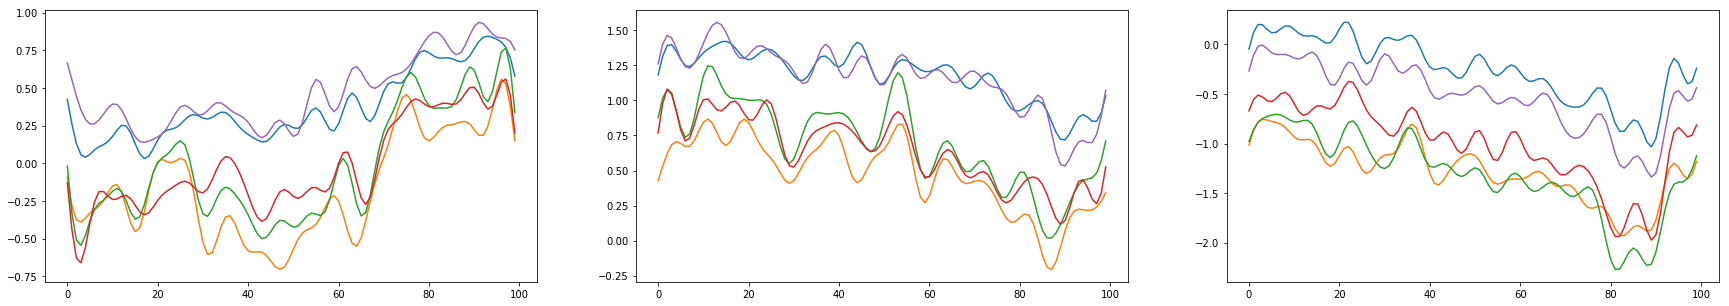

In [48]:
plot_values(smoothed['train_set'], n_examples=3, rand=False)

train_set now has shape (32000, 5, 100, 1)
valid_set now has shape (4000, 5, 100, 1)
test_set now has shape (4000, 5, 100, 1)
Smoothing data with exp_moving_avg


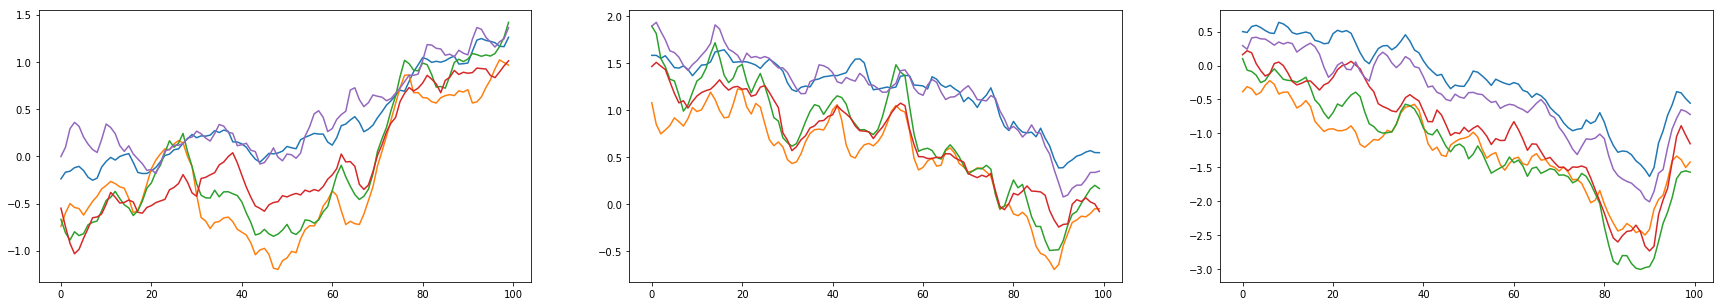

In [49]:
smoothed_exp = smooth_and_save(data_dict, exp_moving_avg)
plot_values(smoothed_exp['train_set'], n_examples=3, rand=False)